# **Frozen product production project**

<table align="center">
  
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1R6GCTt_H_z5AgNNeq1bGhYDnf5JkYazB?authuser=2#scrollTo=YDoUbJbWKJB9">
        <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTR7EtP27gljpJg91k2DVoRgkB84hkMl78bOA&usqp=CAU""  style="padding-bottom:5px;" />
        
  Run this project in Google Colab</a></td>
  
</table>


#DATA INFO
Info about this data set: https://fred.stlouisfed.org/series/IPN31152N
Units:  Index 2012=100, Not Seasonally Adjusted
Frequency:  Monthly
The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
%matplotlib inline

In [1]:
!wget https://raw.githubusercontent.com/gmashik/Time_Series_projects/master/frozen_product_project/data/IPN31152N.csv

--2020-09-09 04:37:08--  https://raw.githubusercontent.com/gmashik/Time_Series_projects/master/frozen_product_project/data/IPN31152N.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11428 (11K) [text/plain]
Saving to: ‘IPN31152N.csv’

IPN31152N.csv       100%[===================>]  11.16K  --.-KB/s    in 0s      

2020-09-09 04:37:08 (80.3 MB/s) - ‘IPN31152N.csv’ saved [11428/11428]



In [4]:
df = pd.read_csv('IPN31152N.csv',index_col='DATE',parse_dates=True)

In [7]:
df.head(3)

Production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350

In [6]:
df.columns = ['Production']

In [8]:
df.head(3)

Production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350

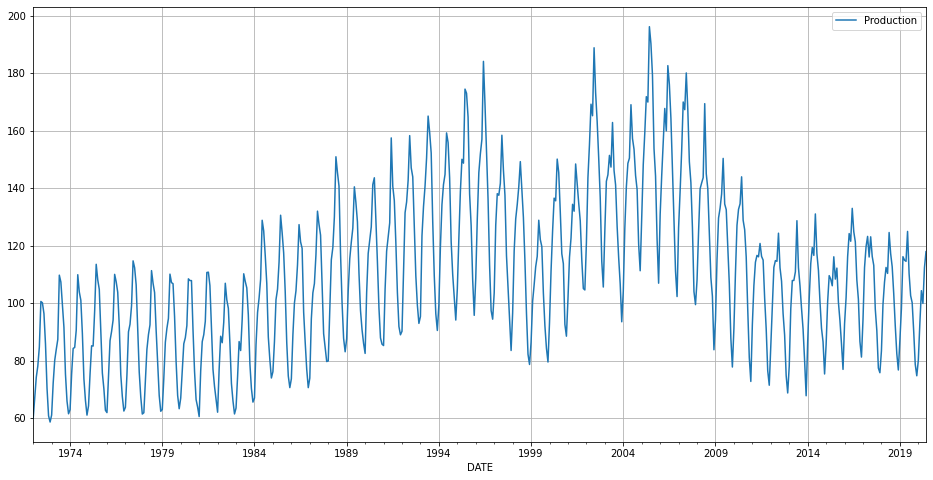

In [17]:
df.plot(figsize=(16,8))
plt.grid()

## **Train test data split**

In [83]:
test_ind = len(df)-int(len(df)*10/100)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]


In [84]:
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [85]:
window_size = 18
n_features=1
generator =tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=window_size, batch_size=1)

## **Define model**

In [97]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64 ,activation='relu', input_shape=(window_size, n_features)),
  tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam', loss='mse')

In [98]:
validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_test,scaled_test, length=window_size, batch_size=1)

In [99]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
506/506 [==============================] - 4s 8ms/step - loss: 0.0298 - val_loss: 0.0129
Epoch 2/20
506/506 [==============================] - 4s 7ms/step - loss: 0.0244 - val_loss: 0.0113
Epoch 3/20
506/506 [==============================] - 4s 7ms/step - loss: 0.0195 - val_loss: 0.0081
Epoch 4/20
506/506 [==============================] - 4s 7ms/step - loss: 0.0106 - val_loss: 0.0032
Epoch 5/20
506/506 [==============================] - 4s 8ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 6/20
506/506 [==============================] - 4s 8ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 7/20
506/506 [==============================] - 4s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/20
506/506 [==============================] - 4s 7ms/step - loss: 0.0028 - val_loss: 0.0018


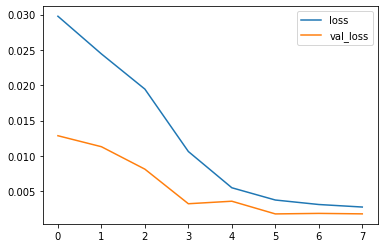

In [100]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [101]:
predictions = []

first_batch = scaled_train[-window_size:]
model_batch = first_batch.reshape((1, window_size, n_features))

for i in range(len(test)):
    pred = model.predict(model_batch)[0]
    predictions.append(pred) 
    model_batch = np.append(model_batch[:,1:,:],[[pred]],axis=1)

In [102]:
inversed_predictions = scaler.inverse_transform(predictions)

In [103]:
test['Predictions'] = inversed_predictions

In [104]:
test.tail(5)

Production  Predictions
DATE                               
2020-02-01     92.9646    74.779003
2020-03-01    104.3522    83.324332
2020-04-01     99.9172    91.782384
2020-05-01    112.3811   100.352319
2020-06-01    117.9333   104.961725

## **Plot predictions versus the True test values**

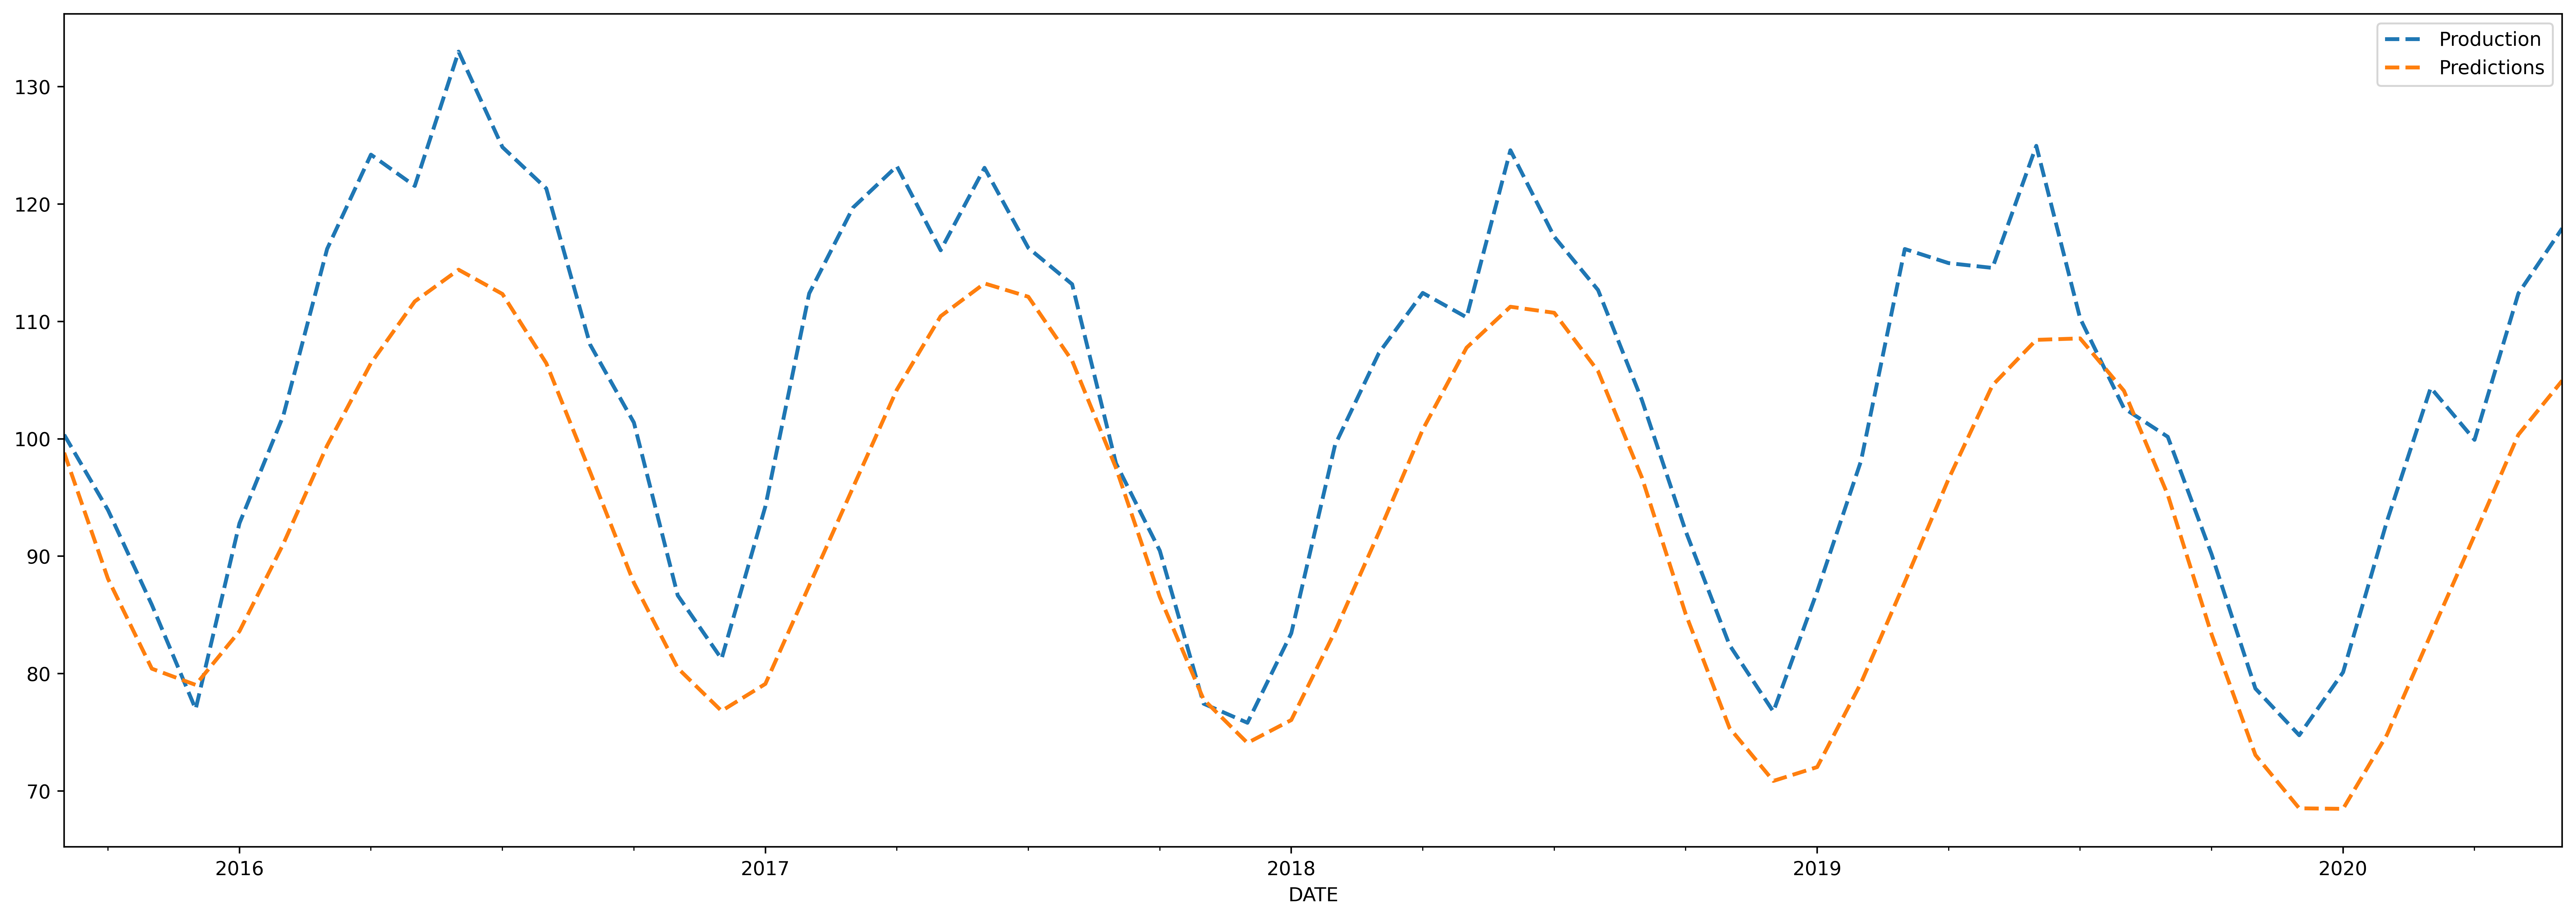

In [162]:
fig=plt.figure(figsize=(18,6),dpi=500)
ax=fig.add_axes([0,0,1,1])
test.plot(ax=ax,linewidth=2,linestyle='--')

In [106]:
print("Mean squared error: ",np.sqrt(mean_squared_error(test['Production'],test['Predictions'])))

Mean squared error:  12.24690046744801


### **The prediction is not very bad. So move with this to retrain the model and make some forcast**

In [116]:
full_scaler = MinMaxScaler(feature_range=(0,1))
scaled_full_data = full_scaler.fit_transform(df)
window_size = 12 # Length of the output sequences (in number of timesteps)
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_full_data, scaled_full_data, length=window_size, batch_size=1)

In [117]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64 ,activation='relu', input_shape=(window_size, n_features)),
  tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)

Epoch 1/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0224
Epoch 2/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0093
Epoch 3/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0054
Epoch 4/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 5/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0045
Epoch 6/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0039
Epoch 7/10
570/570 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 8/10
570/570 [==============================] - 4s 6ms/step - loss: 0.0036
Epoch 9/10
570/570 [==============================] - 4s 7ms/step - loss: 0.0033
Epoch 10/10
570/570 [==============================] - 3s 6ms/step - loss: 0.0032


In [134]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-window_size:]
current_batch = first_eval_batch.reshape((1, window_size, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [135]:
forecast = scaler.inverse_transform(forecast)

In [136]:
forecast.shape

(24, 1)

In [137]:
df.iloc[-1]

Production    117.9333
Name: 2020-06-01 00:00:00, dtype: float64

In [138]:
forecast_index = pd.date_range(start='2020-07-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [139]:
forecast_df

Forecast
2020-07-01  112.995181
2020-08-01  106.214916
2020-09-01   98.050406
2020-10-01   88.541884
2020-11-01   81.534787
2020-12-01   80.336095
2021-01-01   85.094802
2021-02-01   93.103867
2021-03-01  100.586762
2021-04-01  107.237765
2021-05-01  113.441294
2021-06-01  115.742485
2021-07-01  112.934478
2021-08-01  106.071715
2021-09-01   96.762459
2021-10-01   87.762074
2021-11-01   82.537703
2021-12-01   82.548426
2022-01-01   87.088087
2022-02-01   94.207677
2022-03-01  101.976256
2022-04-01  108.976330
2022-05-01  113.967991
2022-06-01  115.435921

In [156]:
fig=plt.figure(figsize=(18,6),dpi=1000)
ax=fig.add_axes([0,0,1,1])
df.plot(ax=ax,linewidth=2)
forecast_df.plot(ax=ax,linewidth=3,color='r',linestyle='--')

# **Conclusion**

**Time series data is very difficult to predict. However our simple model grasp a very good projection on future data. More architecture tuning can be used a achieve more accurate prediction.**